c:\Users\ej.garcia\AppData\Local\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


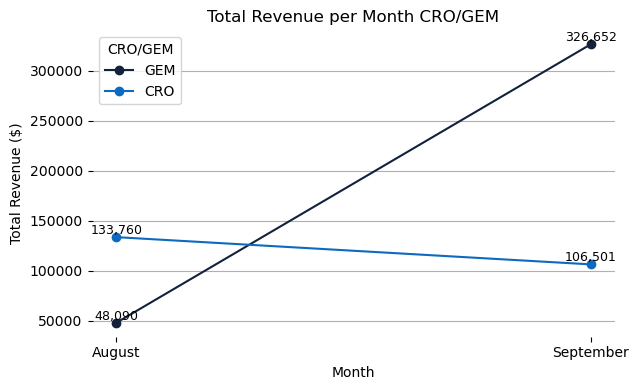

In [11]:
## Importamos librerias
import pyodbc
import numpy as np
import pandas as pd
from datetime import date
import os
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt

# Rutal al json
SERVICE_ACCOUNT_FILE = r"\\vspmdhq-bi\BI_Server_F\BI_for_Reservations\GCP Python credentials\nh-ops.json"

# Cargar credenciales
Credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)

# Crer cliente
client = bigquery.Client(credentials=Credentials,project='nh-ops')

## Query Google Cloud
df = """
SELECT 
  Hotel_Name,
  EXTRACT(MONTH FROM Production_Date) AS Month_Num,
  FORMAT_DATE('%B',Production_Date) as Month_Production, 
  "CRO" AS CRO_GEM,
  SUM(Total_Room_Revenue_Fin_LC) AS RoomRev_Fin_LC,
  SUM(Total_FB_Revenue_Fin_LC) AS FB_Rev_Fin_LC,
  SUM(Total_Other_Revenue_Fin_LC) AS ORev_Fin_LC,
  SUM(Meetings_Room_Revenue_Fin_LC) AS Meetings_Rev_Fin_LC,
  SUM(Total_Revenue_Fin_LC) AS TRev_Fin_LC,
  SUM(Room_Nights) AS RN
FROM `nh-spit-resevations.Commercial_Mirror.CM_Core_Extended`
WHERE Channel_Group_NH = 'CRO'
AND Hotel_ID = 'USNY.MADIS'
AND Production_Date BETWEEN '2025-08-01' AND CURRENT_DATE()-2
GROUP BY
  Hotel_Name,
  Month_Num,
  Month_Production,
  CRO_GEM

UNION ALL

SELECT 
  Hotel_Name,
  EXTRACT(MONTH FROM Production_Date) AS Month_Num,
  FORMAT_DATE('%B',Production_Date) as Month_Production, 
  "GEM" AS CRO_GEM,
  SUM(Total_Room_Revenue_Fin_LC) AS RoomRev_Fin_LC,
  SUM(Total_FB_Revenue_Fin_LC) AS FB_Rev_Fin_LC,
  SUM(Total_Other_Revenue_Fin_LC) AS ORev_Fin_LC,
  SUM(Meetings_Room_Revenue_Fin_LC) AS Meetings_Rev_Fin_LC,
  SUM(Total_Revenue_Fin_LC) AS TRev_Fin_LC,
  SUM(Room_Nights) AS RN
FROM `nh-spit-resevations.Commercial_Mirror.CM_Core_Extended`
WHERE Channel_Group_NH = 'GEM'
AND Hotel_ID = 'USNY.MADIS'
AND Production_Date BETWEEN '2025-08-01' AND CURRENT_DATE()-2
  GROUP BY
  Hotel_Name,
  Month_Num,
  Month_Production,
  CRO_GEM
ORDER BY 
  Month_Production DESC

"""

df= client.query(df).to_dataframe()


#Transformamos columnas numéricas
df['Meetings_Rev_Fin_LC'] = df['Meetings_Rev_Fin_LC'].astype(float).round(2)
df['RoomRev_Fin_LC'] = df['RoomRev_Fin_LC'].astype(float).round(2)
df['FB_Rev_Fin_LC'] = df['FB_Rev_Fin_LC'].astype(float).round(2)
df['ORev_Fin_LC'] = df['ORev_Fin_LC'].astype(float).round(2)
df['TRev_Fin_LC'] = df['TRev_Fin_LC'].astype(float).round(2)
df['RN'] = df['RN'].astype(int)


#Ordenamos por Mont_Num para poder graficar bien
df = df.sort_values("Month_Num")


#Seleccionamos las columnas que nos queremos quedar
df = df[['Hotel_Name','Month_Production', 'CRO_GEM',
       'RoomRev_Fin_LC', 'FB_Rev_Fin_LC', 'ORev_Fin_LC',
       'Meetings_Rev_Fin_LC', 'TRev_Fin_LC','RN']]


# Graficamos
plt.figure(figsize=(6.5,4),facecolor= 'none')
colores = {"GEM" :"#13213C",
           "CRO" : "#0D6ABF" }


for i in df["CRO_GEM"].unique():
    subset = df[df["CRO_GEM"] == i]
    plt.plot(
        subset["Month_Production"],
        subset["TRev_Fin_LC"],
        marker = "o",
        label = i,
        color = colores.get(i,None)
    )
    # Etiquetas sobre las lineas
    for x, y in zip(subset["Month_Production"], subset["TRev_Fin_LC"]):
            plt.text(x, y, f"{y:,.0f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.title("Total Revenue per Month CRO/GEM")
plt.legend(title="CRO/GEM")
plt.grid(axis = 'y')
plt.box(False) # Quitar borde del gráfico
plt.tight_layout()
plt.savefig("grafico.png") 
# plt.close()
plt.show()

## Exportar todo a Excel
with pd.ExcelWriter("Test_CRO.xlsx", engine="xlsxwriter") as writer:
    df.to_excel(writer,sheet_name = "Datos",index = False)
    workbook = writer.book
    worksheet = writer.sheets["Datos"]
    # Quitar Gridlines de excel
    worksheet.hide_gridlines(2)
    ## Ajustar Ancho de las columnas
    for i, col in enumerate(df.columns):
        max_len = max(df[col].astype(str).map(len).max(),len(col)) + 2
        worksheet.set_column(i,i,max_len)
    #Insert gráfico
    worksheet.insert_image("L2","grafico.png")
    #Ajustar zoom del archivo
    worksheet.set_zoom(80)

    # Crear formato de encabezado personalizado
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': False,
        'valign': 'middle',
        'align': 'center',
        'fg_color': '#13213C',
        'font_color': 'white',
        'border': 1
    })

    # Aplicar formato a los encabezados manualmente
    for col_num, value in enumerate(df.columns):
        worksheet.write(0, col_num, value, header_format)

    # Crear formato de celdas con bordes
    cell_format = workbook.add_format({
        'border': 1
    })

    # Aplicar formato de bordes a todas las celdas de datos
    for row in range(1, len(df) + 1):
        for col in range(len(df.columns)):
            worksheet.write(row, col, df.iloc[row - 1, col], cell_format)

In [10]:
df

,Hotel_Name,Month_Production,CRO_GEM,RoomRev_Fin_LC,RoomRev_Fin_EUR,FB_Rev_Fin_LC,ORev_Fin_LC,Meetings_Rev_Fin_LC,TRev_Fin_LC,TRev_Fin_EUR,RN
2,NH Collection New York Madison Avenue,August,GEM,34039.43,29265.12,149.01,13901.10,0.0,48089.54,41344.59,133
3,NH Collection New York Madison Avenue,August,CRO,124721.26,107228.07,8487.31,551.09,0.0,133759.66,114998.76,533
0,NH Collection New York Madison Avenue,September,GEM,312274.01,271667.82,5716.04,7161.87,1500.0,326651.93,284176.12,612
1,NH Collection New York Madison Avenue,September,CRO,101745.99,88515.57,4754.95,0.00,0.0,106500.94,92652.21,274
